In [1]:
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [2]:
files = zf.ZipFile("trash_dataset.zip",'r')
files.extractall()
files.close()

In [3]:
os.listdir(os.path.join(os.getcwd(),"trash_dataset"))


['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [4]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))

    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [5]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## creating destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

Error: Destination path 'data/train/cardboard\cardboard69.jpg' already exists

In [9]:
## confirming path for the images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/monic/Documents/GitHub/PC/data')

In [10]:
trash = ImageDataBunch.from_folder(path,test="test",bs=16)

In [11]:
trash

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\monic\Documents\GitHub\PC\data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\monic\Documents\GitHub\PC\data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\monic\Documents\GitHub\PC\data

In [12]:
print(trash.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


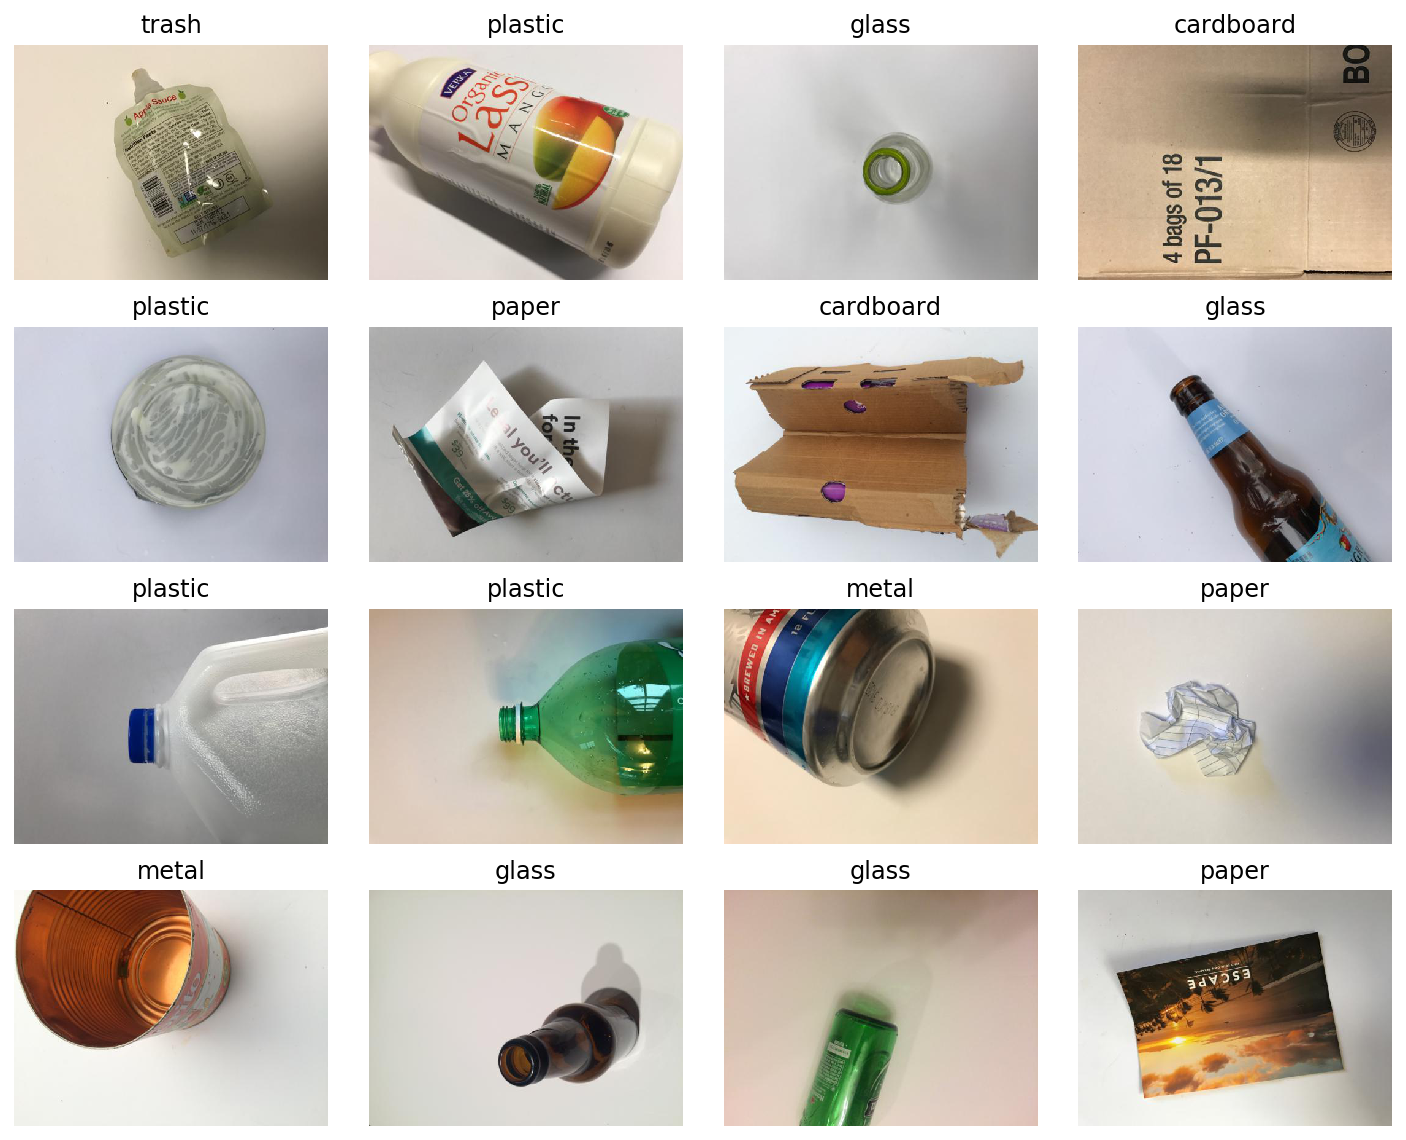

In [13]:
#showing pictures as a test
trash.show_batch(rows=4,figsize=(10,8))


In [14]:
learn = cnn_learner(trash,models.resnet34,metrics=error_rate)

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


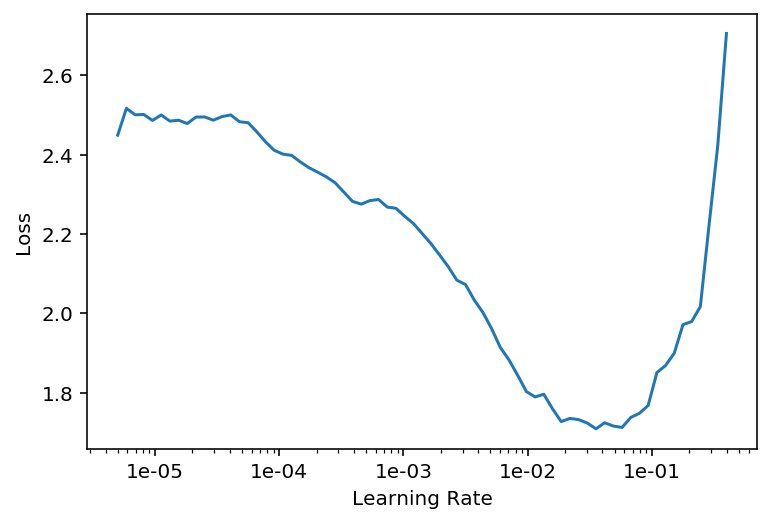

In [16]:
#showing learning rate

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [17]:
#running epochs
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.396951,0.705323,0.231746,01:08
1,0.786480,0.440197,0.139683,01:07
2,0.535908,0.436845,0.147619,01:07
3,0.471584,0.704940,0.209524,01:07
4,0.524352,0.412367,0.131746,01:07
5,0.524012,0.381269,0.123810,01:09
6,0.447991,0.437331,0.160317,01:09
7,0.450503,0.457894,0.142857,01:10
8,0.355166,0.385837,0.126984,01:13
9,0.298045,0.515732,0.171429,01:17


In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [19]:
#using torch + tensor to get the highest error pictures
torch.Tensor.ndim = property(lambda x: len(x.size()))

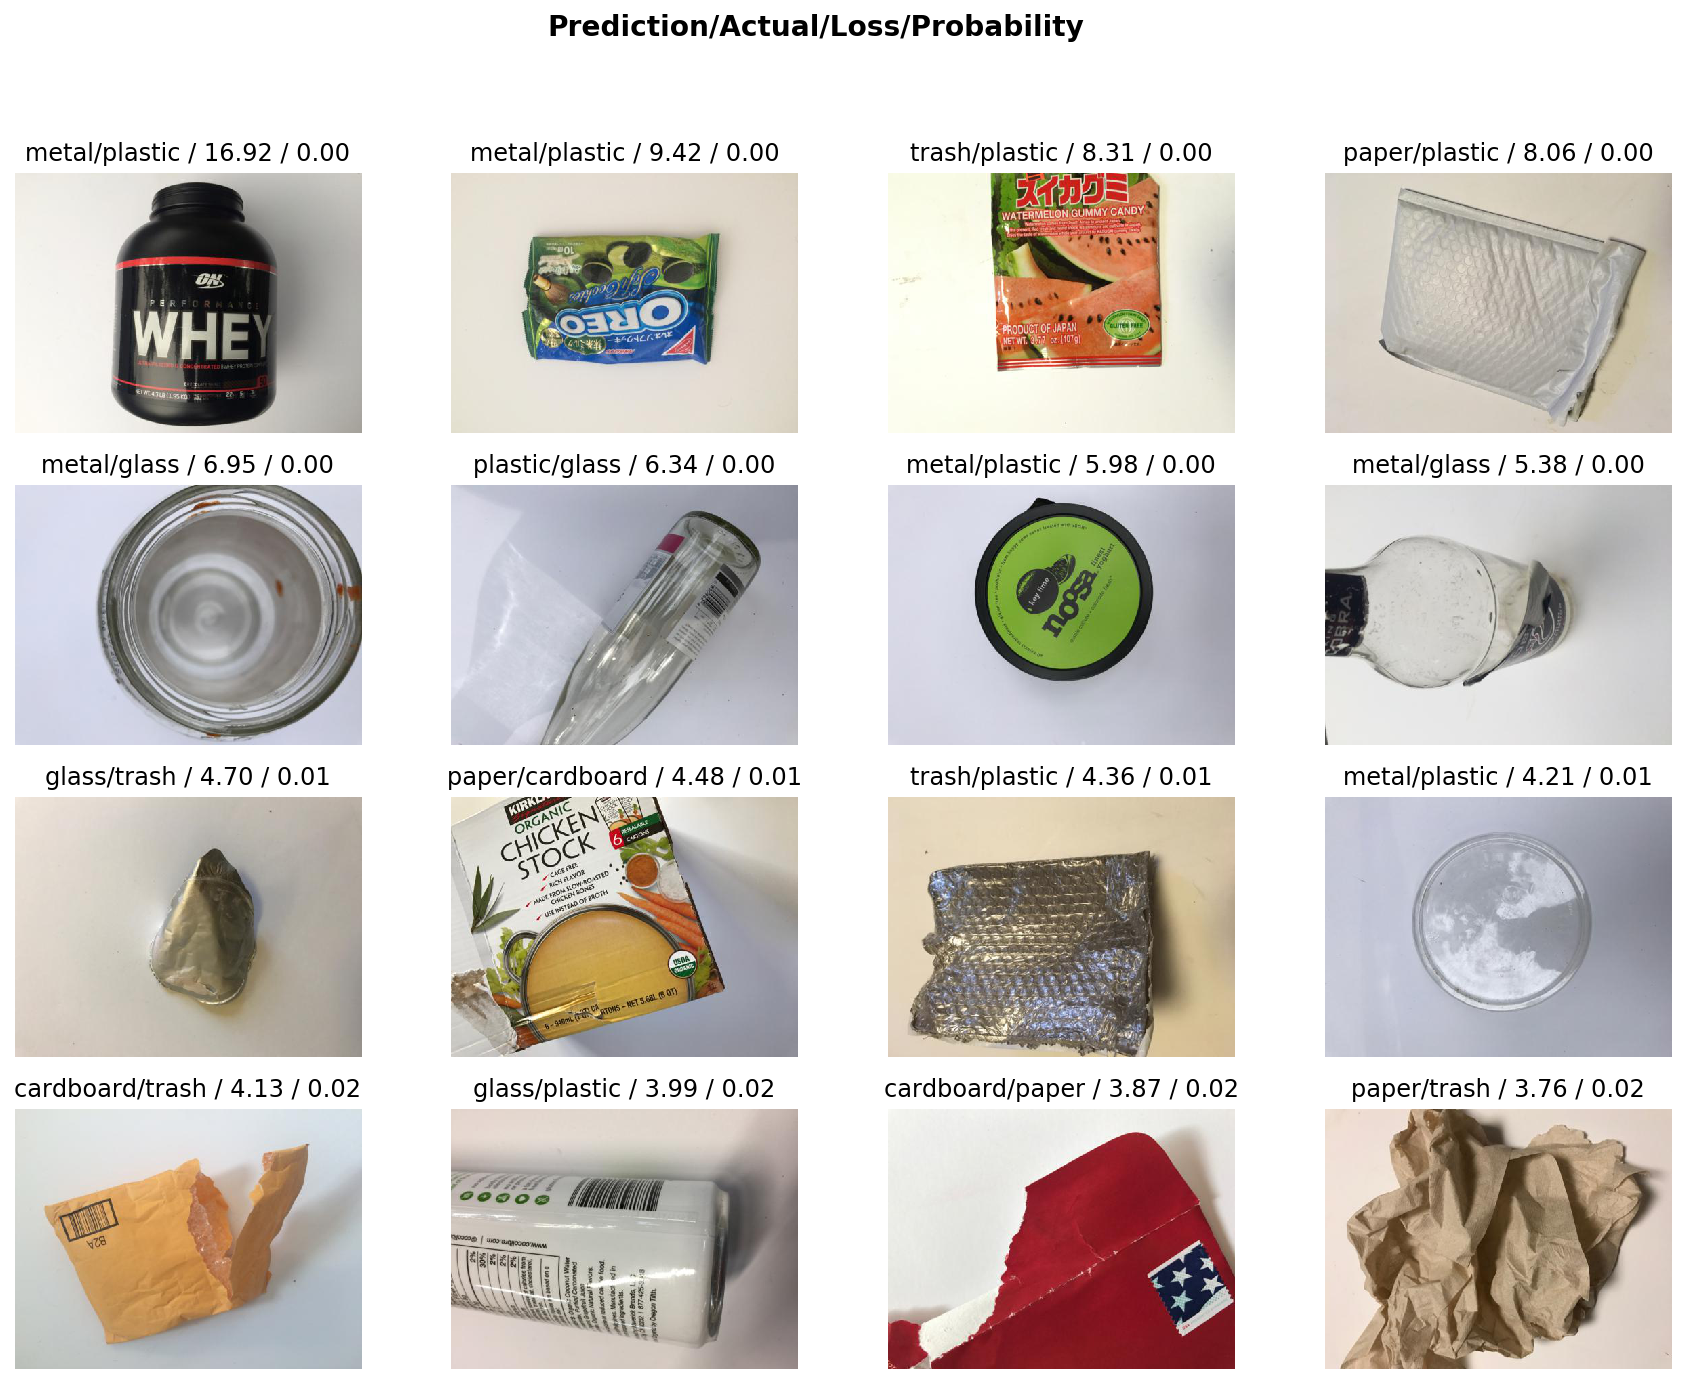

In [21]:
#shows the top 16 images that were identified incorrectly along with their statistics
interp.plot_top_losses(16, figsize=(15,11))

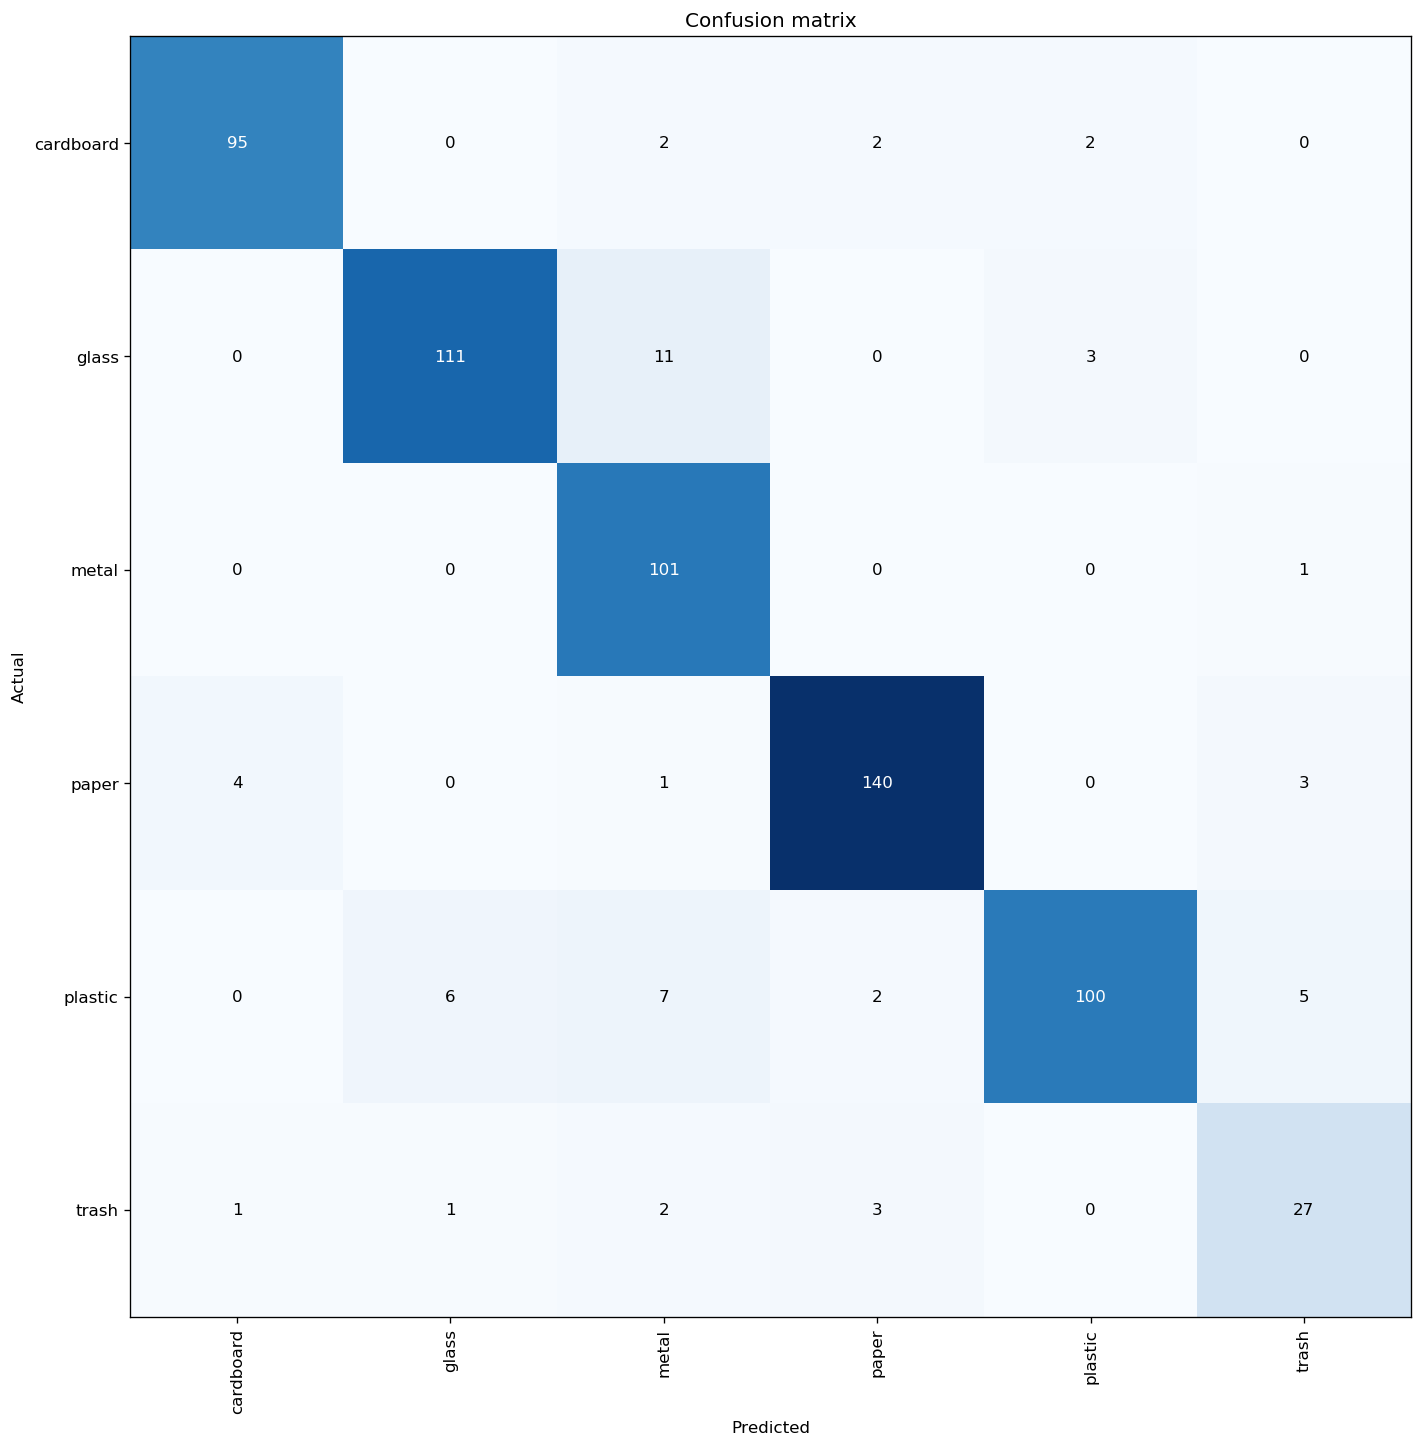

In [22]:
#confusion matrix shows that glass was confused for metal the most
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)


[('glass', 'metal', 11),
 ('plastic', 'metal', 7),
 ('plastic', 'glass', 6),
 ('plastic', 'trash', 5),
 ('paper', 'cardboard', 4),
 ('glass', 'plastic', 3),
 ('paper', 'trash', 3),
 ('trash', 'paper', 3),
 ('cardboard', 'metal', 2),
 ('cardboard', 'paper', 2),
 ('cardboard', 'plastic', 2),
 ('plastic', 'paper', 2),
 ('trash', 'metal', 2)]

In [26]:
#trying to get a higher accuracy rate!
#learner.predict() only predicts on a single image, while learner.get_preds() 
#predicts on a set of images.
preds = learn.get_preds(ds_type=DatasetType.Test)


In [27]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9993e-01, 2.5983e-07, 6.1106e-05, 5.3340e-06, 9.7940e-08, 6.3571e-06],
        [9.5137e-01, 1.2728e-04, 1.3506e-04, 6.1714e-04, 1.8006e-03, 4.5948e-02],
        [9.9994e-01, 8.6673e-09, 1.6244e-07, 8.9723e-07, 8.0223e-07, 6.0518e-05],
        ...,
        [2.0015e-04, 2.0715e-04, 3.3038e-07, 4.9599e-02, 8.6579e-04, 9.4913e-01],
        [2.3715e-04, 4.9338e-05, 5.0853e-06, 4.5277e-01, 6.3382e-05, 5.4687e-01],
        [2.7710e-01, 5.3659e-04, 1.4223e-02, 1.2042e-02, 6.1735e-03, 6.8993e-01]])

In [29]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [30]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [31]:
yhat

['cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'trash',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'cardboard',
 'card

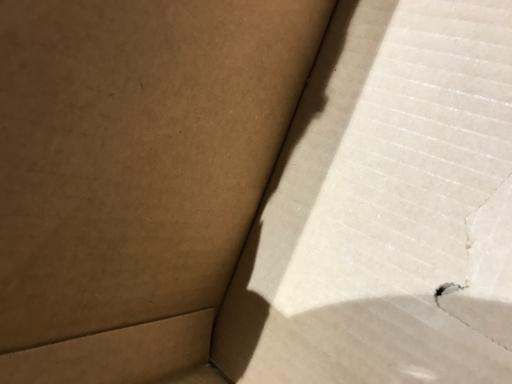

In [32]:
learn.data.test_ds[0][0]

In [33]:
y = []

for label_path in data.test_ds.items:
    y.append(str(label_path))
    
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [34]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

#only one was wrong in this set

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal']
['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']


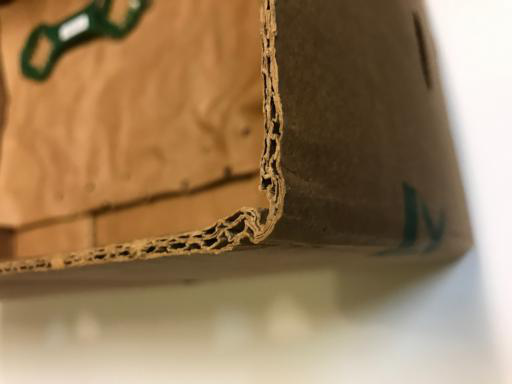

In [48]:
learn.data.test_ds[4][0]
#this is the picture that was predicted wrong by the machine (metal vs cardboard)

In [40]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 94   0   4   2   0   1]
 [  0 109  11   0   6   0]
 [  1   3  98   0   1   0]
 [  0   0   1 145   0   3]
 [  1   4   5   1 110   0]
 [  1   1   5   2   2  24]]


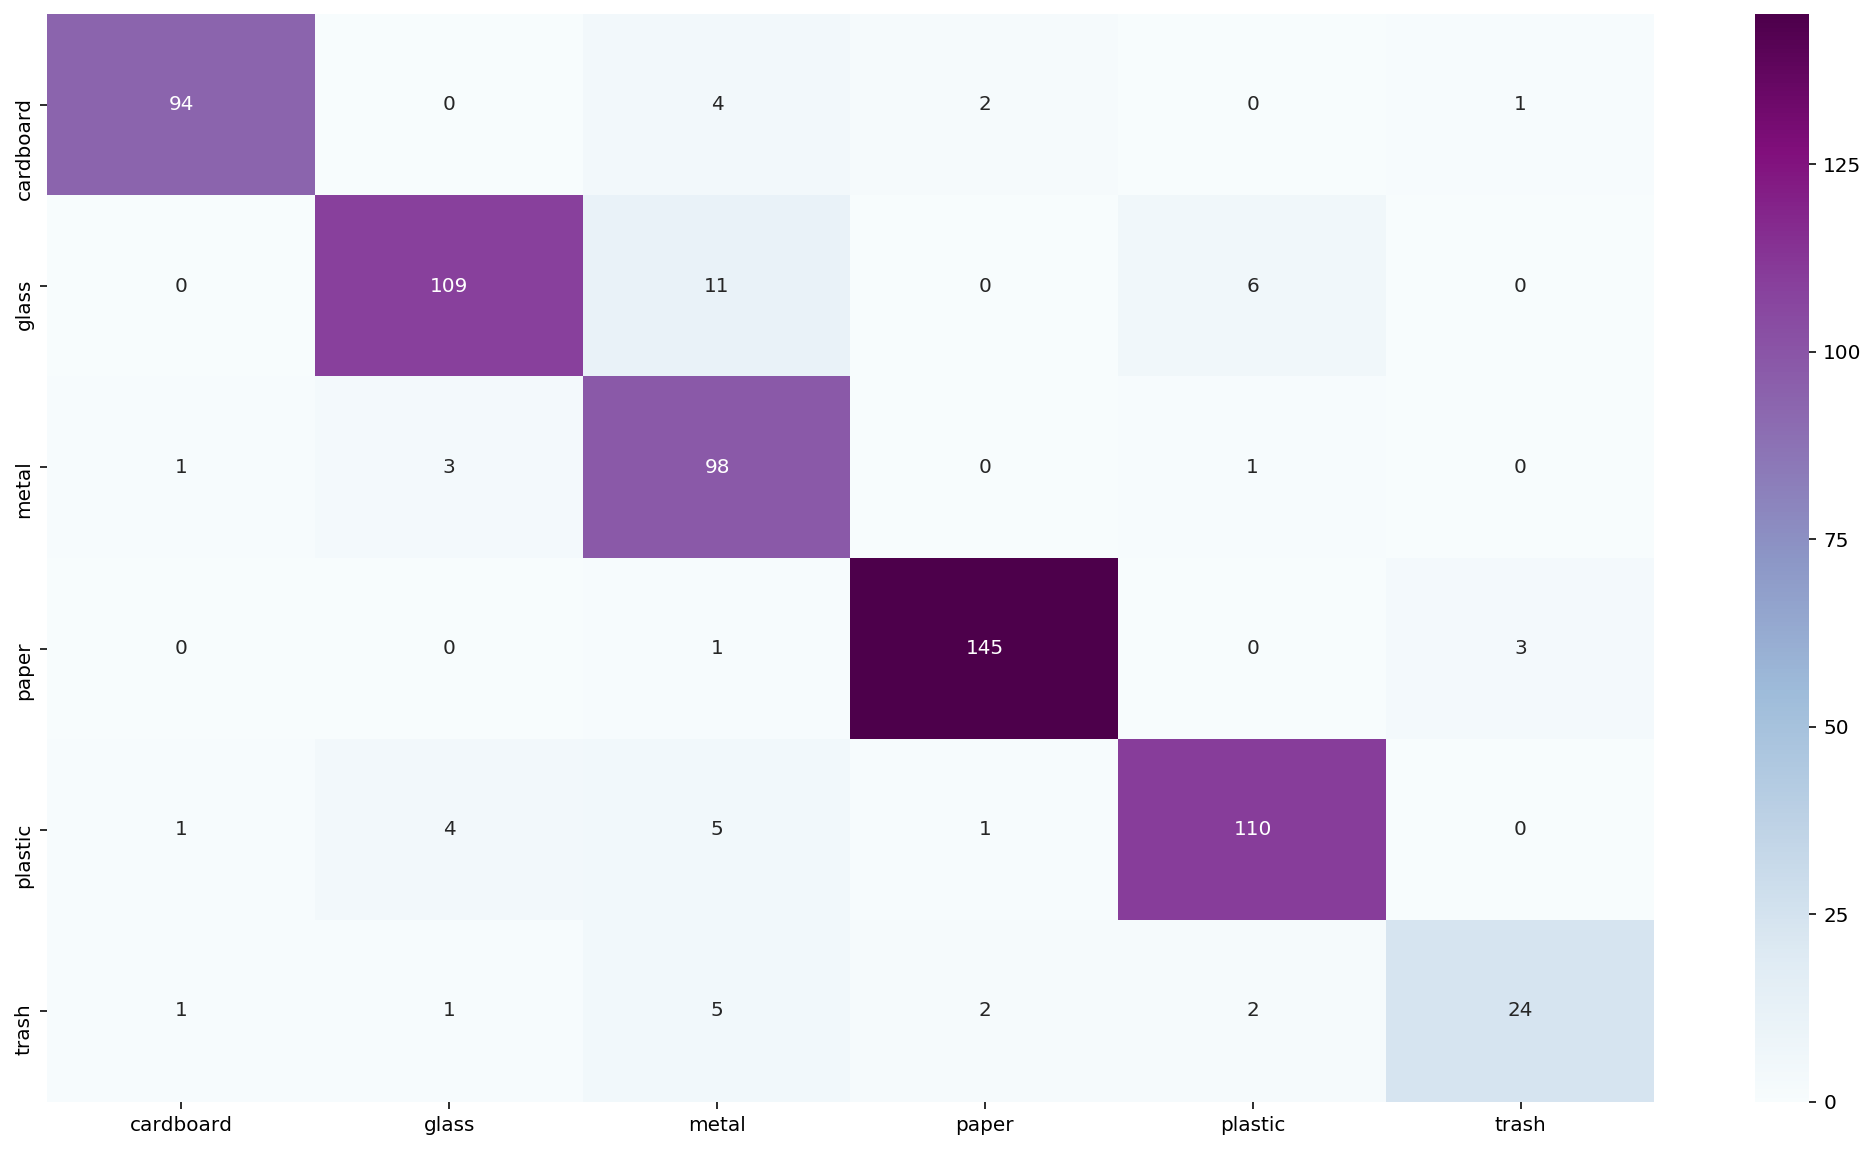

In [69]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(18,10))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="BuPu")
plt.autoscale()
#used seaborn heatmaps library to make it pretty
#need to fix this because it's cut off but it shows most of the data
#edit: fixed with plt.autoscale!

In [42]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
            
#accuracy equation! assigning correct to how much the machine got right

In [43]:
#putting correct into the accuracy equation divided by the total amount
accuracy = correct/sum(sum(cm))
accuracy

0.9133858267716536